In [102]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [103]:
import os
import sys
from copy import deepcopy

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.spatial as sps
from numba import jit
from scipy import stats

sys.path.append("../")

In [104]:
import lusim as sim
import network as nn
import objective as obj
import optimize as opt
import project_utilities as utils
from draw_neural_net import draw_neural_net, draw_weighted_neural_net, get_rgb
from nscore import NormalScoreTransformer

In [105]:
mpl.rcParams["grid.linestyle"] = ":"
mpl.rcParams["axes.grid"] = True

In [106]:
rng = np.random.default_rng(seed=6875)

In [107]:
prefix = "2D_NG_"

# Load Image

533 800


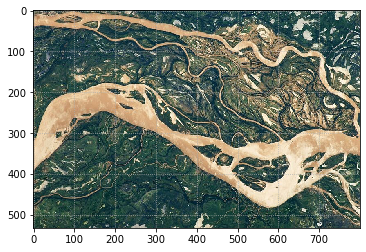

In [108]:
import PIL

with PIL.Image.open("parana-river-braided-12.jpg") as im:
    reference = np.asarray(im)
    reference = utils.normalize(np.mean(reference, axis=-1) / 255)
    plt.imshow(im)
ny = reference.shape[0]
nx = reference.shape[1]
print(ny, nx)

In [109]:
reference.shape

(533, 800)

# Grid Definition

In [110]:
x0 = 0.5
y0 = 0.5
dx = 1
dy = 1
nxy = nx * ny

X, Y = np.meshgrid(
    np.linspace(x0, x0 + (nx - 1) * dx, nx),
    np.linspace(y0, y0 + (ny - 1) * dy, ny),
)
P = np.concatenate((X.reshape(nxy, 1), Y.reshape(nxy, 1)), axis=1)

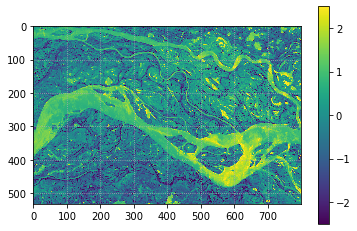

In [111]:
# load target mixture for reference
reference = (
    NormalScoreTransformer().transform(reference.flatten()).reshape(ny, nx)
)
im = plt.imshow(reference, vmin=-2.5, vmax=2.5)
plt.colorbar(im)

# Sample Drillholes

In [179]:
ndh = 20
ncomps = ny
dh = np.zeros(ncomps)
var = "var"
dhid = "dhid"
comps = pd.DataFrame(index=np.arange(ndh * ncomps), columns=[var])
comps[dhid] = np.repeat(np.arange(ndh), ncomps)
idxs = np.linspace(nx / ndh, nx - (nx / ndh), ndh, dtype=int)
for i in range(ndh):
    comps.loc[comps[dhid] == i, var] = reference[:, idxs[i]][::-1]
    comps.loc[comps[dhid] == i, "X"] = idxs[i]
    comps.loc[comps[dhid] == i, "Y"] = np.arange(1, ny + 1)
comps = comps[[dhid, "X", "Y", var]]
comps = comps.astype({var: float})

In [180]:
comps

,dhid,X,Y,var
0,0,40.0,1.0,-1.096760
1,0,40.0,2.0,-0.943657
2,0,40.0,3.0,-1.207573
3,0,40.0,4.0,-1.036418
4,0,40.0,5.0,-0.335069
...,...,...,...,...
10655,19,760.0,529.0,0.238318
10656,19,760.0,530.0,0.210117
10657,19,760.0,531.0,0.134053
10658,19,760.0,532.0,-0.536530


In [181]:
comps = comps.iloc[::5]  # every 5th sample
g = comps.groupby(dhid, group_keys=False)
comps = g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True))
comps.sort_values(by=["X", "Y"], inplace=True)
comps.index = np.arange(len(comps))
ncomps = g.size().min()
dhids = comps[dhid].values

# for uid in comps[dhid].unique():
#     print(uid, len(comps.loc[comps[dhid] == uid]))

In [182]:
dh_lens = []
for uid in comps[dhid].unique():
    dh_lens.append(len(comps.loc[comps[dhid] == uid]))
maxdhlen = max(dh_lens)
ndh = len(dh_lens)
print(ndh, maxdhlen)

20 106


In [183]:
locs = comps[["X", "Y"]].values
nd = len(locs)
nd

2120

Text(0, 0.5, 'Y (px)')

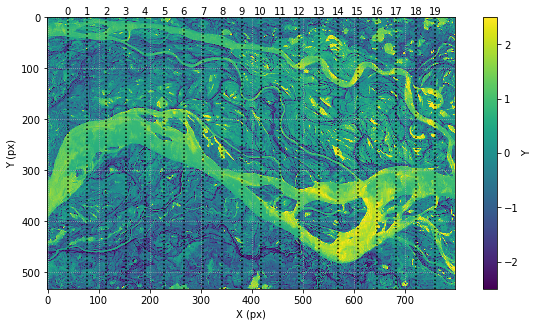

In [184]:
fig, ax = plt.subplots(figsize=(10, 5))
im = ax.imshow(reference, vmin=-2.5, vmax=2.5)
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Y")
for i, idx in enumerate(idxs):
    ax.axvline(idx, ls=":", c="k")
    ax.text(idx, -5, f"{i}", ha="center")
ax.set_xlabel("X (px)")
ax.set_ylabel("Y (px)")

'2d_ng_drillhole_map'

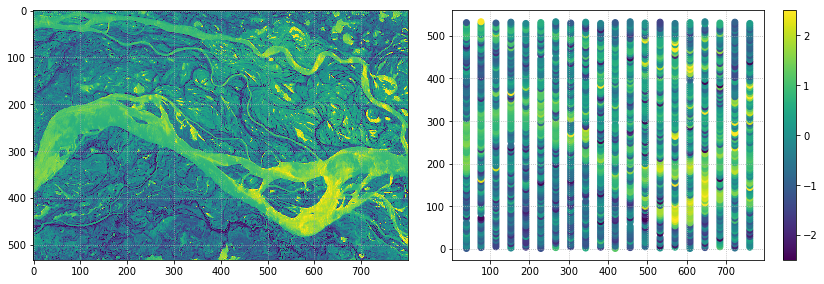

In [194]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
im = axes[0].imshow(reference, vmin=-2.5, vmax=2.5)
plt.colorbar(im, ax=axes[1])
axes[1].scatter(comps["X"], comps["Y"], c=comps[var], vmin=-2.5, vmax=2.5)
utils.savefig(prefix + "drillhole_map")

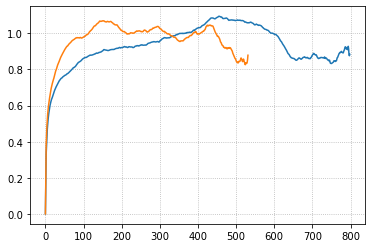

In [195]:
def griddedgam(z):
    """gridded variogram values along x and y axes"""
    nx = z.shape[1]
    ny = z.shape[0]

    gx = np.zeros(nx - 1)
    for i in range(1, nx - 1):
        z0 = z[:, 0 : nx - i]
        z1 = z[:, i:nx]
        dz = (z1 - z0) ** 2
        gx[i] = np.sum(dz) / (2 * (nx - i) * ny)

    gy = np.zeros(ny - 1)
    for i in range(1, ny - 1):
        z0 = z[0 : ny - i, :]
        z1 = z[i:ny, :]
        dz = (z1 - z0) ** 2
        gy[i] = np.sum(dz) / (2 * (ny - i) * nx)

    return [gx, gy]


gx, gy = griddedgam(reference)
plt.plot(gx)
plt.plot(gy)

In [196]:
reference.shape

(533, 800)

# Continous Variogram

In [197]:
from variogrammodel import VariogramModel

In [198]:
vstr = """2    0.1                         -nst, nugget effect
    2    0.5  90.0   0.0   0.0        -it,cc,ang1,ang2,ang3
    25.0  25.0  0.0        -a_hmax, a_hmin, a_vert
    2    0.4  90.0   0.0   0.0        -it,cc,ang1,ang2,ang3
    300.0  100.0  0.0        -a_hmax, a_hmin, a_vert"""

vario = VariogramModel(vstr)

In [199]:
xnlags = int(nx * 2 / 3)
ynlags = int(ny * 2 / 3)

target_x = vario.calcpoints(90, 0, lagdist=1, nlags=xnlags)["Variogram"]
target_y = vario.calcpoints(0, 0, lagdist=1, nlags=ynlags)["Variogram"]

In [300]:
xnlags

10

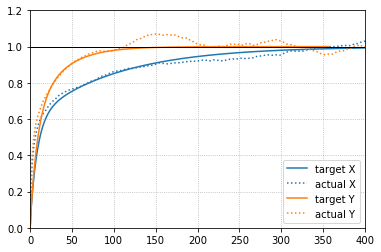

In [200]:
fig, ax = plt.subplots()
ax.plot(target_x, label="target X", c="C0")
ax.plot(gx, ls=":", label="actual X", c="C0")
ax.plot(target_y, label="target Y", c="C1")
ax.plot(gy, ls=":", label="actual Y", c="C1")
ax.axhline(1.0, c="k", lw=1)
ax.set_ylim(0, 1.2)
ax.set_xlim(0, nx * 0.50)
ax.legend(loc=4)

# Indicator Variograms

In [201]:
def indicator_transform(z, zc):
    """indicator transform of z based on cutoffs zc"""
    z = z.flatten()
    zi = np.zeros((len(z), len(zc)))
    ivars = []
    for j, c in enumerate(zc):
        zi[:, j] = np.where(z <= c, 1, 0)
        iprop = np.mean(zi[:, j])
        ivars.append(iprop * (1 - iprop))
    return zi, ivars

In [202]:
quantiles = [0.1, 0.5, 0.9]
thresholds = {q: t for q, t in zip(quantiles, stats.norm.ppf(quantiles))}
thresholds

{0.1: -1.2815515655446004, 0.5: 0.0, 0.9: 1.2815515655446004}

In [203]:
ireference, ivars = indicator_transform(reference, thresholds.values())

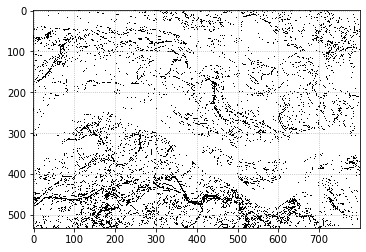

In [204]:
plt.imshow(ireference[:, 0].reshape(ny, nx), vmin=0, vmax=1, cmap="binary")

In [205]:
ivmods = {
    quantiles[0]: VariogramModel(
        """2    0                         -nst, nugget effect
    1    0.9  90.0   0.0   0.0        -it,cc,ang1,ang2,ang3
    2.0  2.0  0.0        -a_hmax, a_hmin, a_vert
    1    0.1  90.0   0.0   0.0        -it,cc,ang1,ang2,ang3
    75.0  80.0  0.0        -a_hmax, a_hmin, a_vert"""
    ),
    quantiles[1]: VariogramModel(
        """2    0                         -nst, nugget effect
    2    0.6  90.0   0.0   0.0        -it,cc,ang1,ang2,ang3
    10.0  10.0  0.0        -a_hmax, a_hmin, a_vert
    2    0.4  90.0   0.0   0.0        -it,cc,ang1,ang2,ang3
    300.0  100.0  0.0        -a_hmax, a_hmin, a_vert"""
    ),
    quantiles[2]: VariogramModel(
        """2    0                         -nst, nugget effect
    2    0.5  90.0   0.0   0.0        -it,cc,ang1,ang2,ang3
    10.0  10.0  0.0        -a_hmax, a_hmin, a_vert
    2    0.5  90.0   0.0   0.0        -it,cc,ang1,ang2,ang3
    150.0  50.0  0.0        -a_hmax, a_hmin, a_vert"""
    ),
}

In [206]:
ivmods

{0.1: <variogrammodel.VariogramModel at 0x260d8e688c8>,
 0.5: <variogrammodel.VariogramModel at 0x260d8e6da08>,
 0.9: <variogrammodel.VariogramModel at 0x260d8e6d388>}

In [207]:
ivarios = {q: [] for q in thresholds}
for q in thresholds:
    ivarios[q].append(
        ivmods[q].calcpoints(90, 0, lagdist=1, nlags=xnlags)["Variogram"].values
    )
    ivarios[q].append(
        ivmods[q].calcpoints(0, 0, lagdist=1, nlags=ynlags)["Variogram"].values
    )
    ivarios[q].append([])  # empty vert direction

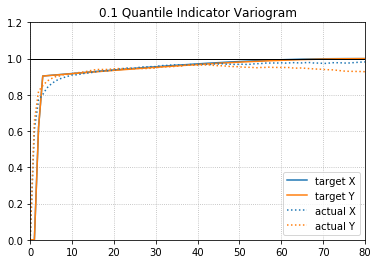

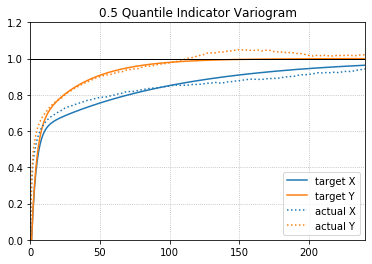

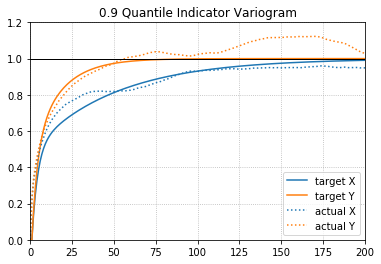

In [208]:
xscale = [0.1, 0.3, 0.25]
for j, q in enumerate(quantiles):
    fig, ax = plt.subplots()
    igx, igy = griddedgam(ireference[:, j].reshape(ny, nx))
    ax.plot(ivarios[q][0], c="C0", label="target X")
    ax.plot(ivarios[q][1], c="C1", label="target Y")
    ax.plot(igx / ivars[j], c="C0", ls=":", label="actual X")
    ax.plot(igy / ivars[j], c="C1", ls=":", label="actual Y")
    ax.set_title(f"{q} Quantile Indicator Variogram")
    ax.axhline(1.0, c="k", lw=1)
    ax.set_ylim(0, 1.2)
    ax.set_xlim(0, nx * xscale[j])
    ax.legend()

In [209]:
# indicator transform of comps
def indicator_transform_df(df, var, threhsolds):
    """Transform var to indicators based on thresholds"""
    ind_cols = [f"{q} Indicator" for q in thresholds.keys()]
    df = df.reindex(columns=df.columns.tolist() + ind_cols)
    df[ind_cols] = 0
    for q, t in thresholds.items():
        df.loc[df[var] <= t, f"{q} Indicator"] = 1
    df = df.astype({col: int for col in ind_cols})
    return df


comps = indicator_transform_df(comps, var, thresholds)
comps.head()

,dhid,X,Y,var,0.1 Indicator,0.5 Indicator,0.9 Indicator
0,0,40.0,1.0,-1.096760,0,1,1
1,0,40.0,6.0,-0.187434,0,1,1
2,0,40.0,11.0,-0.173190,0,1,1
3,0,40.0,16.0,-0.626078,0,1,1
4,0,40.0,21.0,-0.198076,0,1,1


# Runs

In [32]:
def binary_runs(x, runs_above):
    """Calcualte runs and cumulative runs in binary array x"""
    runs_data = {}
    x = np.asarray(x)
    first_run = x[0]  # 1 or 0
    runstart = np.nonzero(np.diff(np.r_[[-np.inf], x, [np.inf]]))[0]
    runs = np.diff(runstart)
    runs = _check_runs_above(first_run, runs, runs_above)
    cum_runs = []
    for run in runs:
        for i in range(run):
            sub_run_length = run - i
            num_sub_runs = i + 1
            cum_runs.append([*[sub_run_length] * num_sub_runs])

    runs_data["runs"] = runs
    runs_data["cum_runs"] = np.array([a for b in cum_runs for a in b])
    runs_data["run_idxs"] = runstart
    runs_data["n_runs"] = len(runs)

    try:  # catch situation where all runs are below/above?
        runs_data["cum_runs_freqs"] = np.bincount(runs_data["cum_runs"])[1:]
        runs_data["runs_freqs"] = np.bincount(runs)[1:]
    except:
        runs_data["cum_runs_freqs"] = np.array([])
        runs_data["runs_freqs"] = np.array([])

    return runs_data


def _check_runs_above(first_run, runs, runs_above=True):
    if runs_above:
        if first_run:
            runs = runs[1::2]
        else:
            runs = runs[0::2]
        return runs
    else:
        return runs

In [33]:
runs_above = True
global_runs = {q: [] for q in thresholds}
maxrun = 50

# merge runs from each drillhole into a global histogram
for q, t in thresholds.items():
    temp_runs = np.zeros(maxrun)
    for uid in comps[dhid].unique():
        dh = comps.loc[comps[dhid] == uid, f"{q} Indicator"].copy()
        run_freqs = binary_runs(dh.values, runs_above)["cum_runs_freqs"][
            :maxrun
        ]
        temp_runs += np.pad(run_freqs, (0, maxrun - len(run_freqs)))
    global_runs[q] = temp_runs

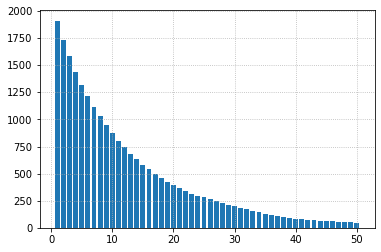

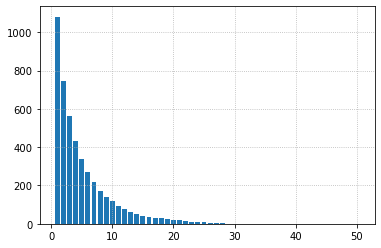

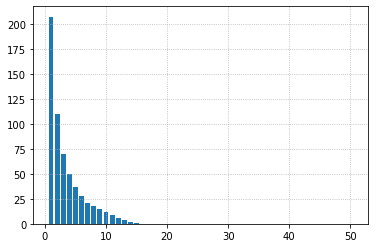

In [34]:
for q in thresholds:
    fig, ax = plt.subplots()
    _ = ax.bar(np.arange(maxrun) + 1, global_runs[q])

# n-Point Connectivity

In [35]:
# # @jit(nopython=True)
# def n_pt_conn(X, nstep):
#     """Global n-point connectivity fucntion of binary matrix X
#     X.shape = (len(dh), ndh)
#     """
#     X = np.asarray(X)
#     nx = X.shape[0]
#     ndh = X.shape[1]
#     phi_n = np.zeros(nstep, dtype=np.float64)
#     for n in range(1, nstep + 1):
#         prod = []
#         for k in range(ndh):
#             x = X[:, k]
#             for i in range(nx - n + 1):
#                 idxs = [i] + [j + i for j in range(n)]
#                 a = [x[int(idx)] for idx in idxs]
#                 p = 1
#                 for i in a:
#                     p *= i
#                 prod.append(p)
#         phi_n[n - 1] = np.mean(np.array(prod, dtype=np.float64))
#     return np.asarray(phi_n)


@jit(nopython=True)
def n_pt_conn(X, nstep):
    """Global n-point connectivity fucntion of binary matrix X
    X.shape = (len(dh), ndh)
    """
    X = np.asarray(X)
    xmax = X.shape[0]
    ndh = X.shape[1]
    phi_n = np.zeros(nstep, dtype=np.float64)

    for n in range(1, nstep + 1):

        prod = np.zeros((xmax - (n - 1)) * ndh, dtype=np.float64)
        temp_idx = np.array([0] + [j for j in range(n)])

        for k in range(ndh):

            x = X[:, k]
            x = x[x > -1]
            nx = len(x)

            for i in range(nx - n + 1):

                idxs = temp_idx + i
                arr = x[idxs]

                p = 1
                for a in arr:
                    p *= a

                ii = i + (xmax - (n - 1)) * k

                prod[ii] = p

        phi_n[n - 1] = np.mean(prod)

    return phi_n

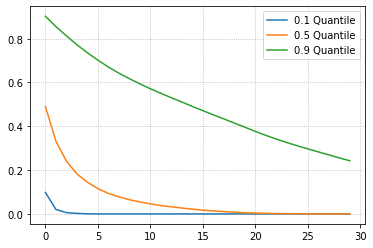

In [36]:
nstep = 30
target_npoint = {}

for j, q in enumerate(thresholds):

    X = np.zeros((ncomps, ndh))
    for i, uid in enumerate(comps[dhid].unique()):
        X[:, i] = comps.loc[comps[dhid] == uid, f"{q} Indicator"].values
    target_npoint[q] = n_pt_conn(X, nstep=nstep)
    plt.plot(target_npoint[q], label=f"{q} Quantile")
    plt.legend()

# Factor Variogram Models

In [219]:
sph_fact = 5
exp_fact = 5
gau_fact = 5
n_fact = sph_fact + exp_fact + gau_fact

max_range = int(nx * 0.66)
min_range = int(nx * 0.10)

sph_ranges_x = np.linspace(min_range, max_range, num=sph_fact, endpoint=False)
exp_ranges_x = np.linspace(min_range, max_range, num=exp_fact, endpoint=False)
gau_ranges_x = np.linspace(min_range, max_range, num=gau_fact, endpoint=False)

sph_ranges_y = np.linspace(
    min_range, max_range / 2, num=sph_fact, endpoint=False
)
exp_ranges_y = np.linspace(
    min_range, max_range / 2, num=exp_fact, endpoint=False
)
gau_ranges_y = np.linspace(
    min_range, max_range / 2, num=gau_fact, endpoint=False
)

sph_struct = [1] * sph_fact
exp_struct = [2] * exp_fact
gau_struct = [3] * gau_fact

ranges_x = np.concatenate((sph_ranges_x, exp_ranges_x, gau_ranges_x))
ranges_y = np.concatenate((sph_ranges_y, exp_ranges_y, gau_ranges_y))
structs = np.concatenate((sph_struct, exp_struct, gau_struct))

In [220]:
structs

array([1, 1, 1, 2, 2, 2, 3, 3, 3])

In [221]:
ranges_x

array([ 80.        , 229.33333333, 378.66666667,  80.        ,
       229.33333333, 378.66666667,  80.        , 229.33333333,
       378.66666667])

In [222]:
ranges_y

array([ 80.        , 141.33333333, 202.66666667,  80.        ,
       141.33333333, 202.66666667,  80.        , 141.33333333,
       202.66666667])

# Factor Simulation
- Each initial factor is simulated with a different random number seed and a completely different variogram
- Each initial factor has a single pure structure that reflects something with unique spatial correlation that could translate to something combined with other factors

## Grid

In [223]:
# Ysim = np.zeros([nxy, n_fact + 1])
# Ysim[:, 0] = rng.normal(size=nxy)  # nugget
# C = []
# for i, (st, rx, ry) in enumerate(zip(structs, ranges_x, ranges_y)):
#     if st < 3:
#         c = sim.pairwisecova_2D(
#             P, ranges_x=[rx], ranges_y=[ry], vtypes=[st], c0=0.0, cc=[1.0]
#         )
#     else:  # small nugget to avoid singular matrix with Gaussian model
#         c = sim.pairwisecova_2D(
#             P, ranges_x=[rx], ranges_y=[ry], vtypes=[st], c0=0.001, cc=[0.999]
#         )
#     Ysim[:, i + 1] = sim.lusim(c, nr=1, seed=78451 + i * 1000)
#     C.append(c)

In [224]:
# fig, axes = plt.subplots(4, 4, figsize=(10, 10))
# for i, (ax, st, rx, ry) in enumerate(
#     zip(axes.flatten(), structs, ranges_x, ranges_y),
# ):
#     im = ax.imshow(
#         Ysim[:, i + 1].reshape(ny, nx), origin="lower", vmin=-2.5, vmax=2.5
#     )
#     #     plt.colorbar(im, ax=ax)
#     ax.set_title(f"st:{st} rx:{rx} ry:{ry}")
# axes[-1, -1].imshow(
#     Ysim[:, 0].reshape(ny, nx), origin="lower", vmin=-2.5, vmax=2.5
# )
# fig.tight_layout()

## Data Locations

In [225]:
coords = comps[["X", "Y"]].values
nxyd = len(coords)
Ysimd = np.zeros([nxyd, n_fact + 1])
Ysimd[:, 0] = rng.normal(size=nxyd)  # nugget
C = []
for i, (st, rx, ry) in enumerate(zip(structs, ranges_x, ranges_y)):
    if st < 3:
        c = sim.pairwisecova_2D(
            coords, ranges_x=[rx], ranges_y=[ry], vtypes=[st], c0=0.0, cc=[1.0]
        )
    else:  # small nugget to avoid singular matrix with Gaussian model
        c = sim.pairwisecova_2D(
            coords,
            ranges_x=[rx],
            ranges_y=[ry],
            vtypes=[st],
            c0=0.001,
            cc=[0.999],
        )
    Ysimd[:, i + 1] = sim.lusim(c, nr=1, seed=78451 + i * 1000)
    C.append(c)

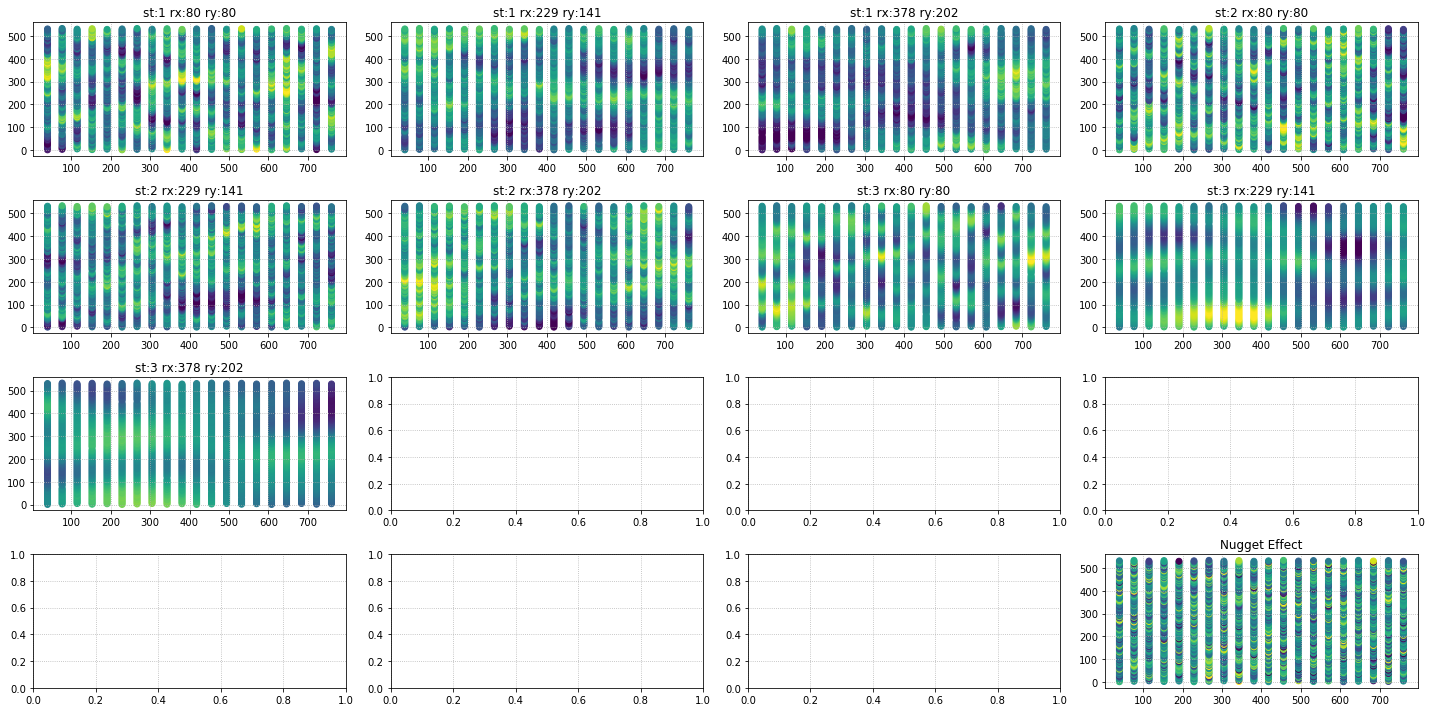

In [226]:
fig, axes = plt.subplots(4, 4, figsize=(20, 10))
for i, (ax, st, rx, ry) in enumerate(
    zip(axes.flatten(), structs, ranges_x, ranges_y),
):
    im = ax.scatter(
        coords[:, 0], coords[:, 1], c=Ysimd[:, i + 1], vmin=-2.5, vmax=2.5
    )
    #     plt.colorbar(im, ax=ax)
    ax.set_title(f"st:{int(st)} rx:{int(rx)} ry:{int(ry)}")
axes[-1, -1].scatter(
    coords[:, 0], coords[:, 1], c=Ysimd[:, 0], vmin=-2.5, vmax=2.5
)
axes[-1, -1].set_title("Nugget Effect")
fig.tight_layout()

# Network LMR

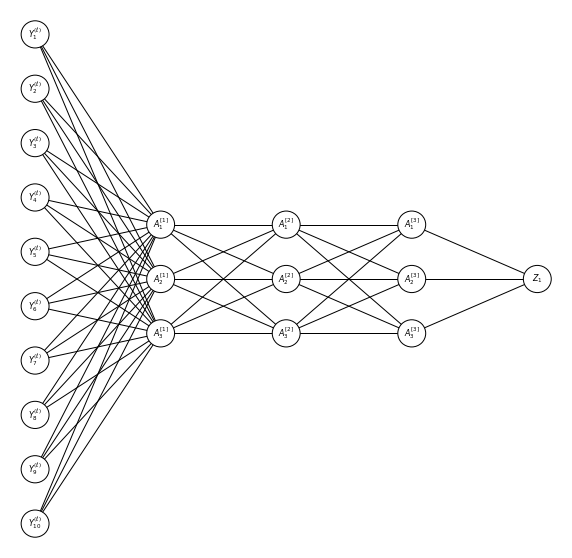

In [266]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.axis("off")
layer_dims = [n_fact + 1, 5, 5, 5, 1]
# layer_dims = [n_fact + 1, 1]
draw_neural_net(ax, 0.05, 0.95, 0.0, 1.0, layer_dims, "Y", "A", "Z", 8)

In [267]:
parameters = nn.intitialize_layer_params(layer_dims, 5841044, "uniform")

In [268]:
# connections = []
# for k, v in parameters.items():
#     if "W" in k:
#         connections.append(v.shape[0] * v.shape[1])
#     print(k, "shape:", v.shape)
# tconn = np.sum(connections)
# print("Total connections:", tconn)

connections = []
biases = []
for k, v in parameters.items():
    if "W" in k:
        connections.append(v.shape[0] * v.shape[1])
    if "b" in k:
        biases.append(v.shape[0] * v.shape[1])
    print(k, "shape:", v.shape)
tconn = np.sum(connections)
tbias = np.sum(biases)
print("Total connections:", tconn)
print("Total biases:", tbias)

W1 shape: (3, 10)
b1 shape: (3, 1)
W2 shape: (3, 3)
b2 shape: (3, 1)
W3 shape: (3, 3)
b3 shape: (3, 1)
W4 shape: (1, 3)
b4 shape: (1, 1)
Total connections: 51
Total biases: 10


In [269]:
afunc = nn.sigmoid
AL = nn.linear_forward(Ysimd, parameters, afunc)

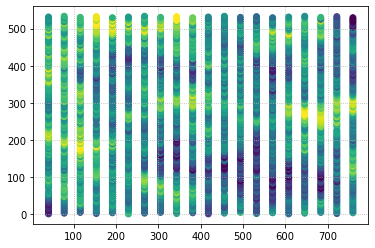

In [271]:
plt.scatter(coords[:, 0], coords[:, 1], c=AL, vmin=-2.5, vmax=2.5)

# Objective Components

## Utils

In [272]:
def vector_to_matrices(parameters, connections, x):
    """reshape 1D vector into appropriate matrices"""
    L = len(parameters) // 2
    num_wts = np.cumsum([0] + connections)
    for ell in range(1, L + 1):
        shape = parameters["W" + str(ell)].shape
        parameters["W" + str(ell)] = x[num_wts[ell - 1] : num_wts[ell]].reshape(
            shape
        )
    return parameters

## Variograms

In [273]:
def generate_lag_dict(coords, values, nlags, azm, atol, maxlag):
    """generate dictionary of pair indices for each variogram lag"""
    from scipy.spatial.distance import squareform
    from skgstat import DirectionalVariogram

    lag_dict = {}
    DV = DirectionalVariogram(
        coords,
        values,
        azimuth=azm,
        tolerance=atol,
        n_lags=nlags,
        maxlag=maxlag,
    )
    tril = np.tril_indices(len(coords), k=0)
    gmat = squareform(DV.lag_groups())
    gmat[tril] = -1

    for i in range(nlags):
        lag_dict[i] = np.argwhere(gmat == i)

    return lag_dict, DV.bins.tolist()


xnlags = 10
ynlags = 20
xazm = 0  # horizontal
yazm = 90  # vertical
atol = 25
maxlag = int(nx * 0.66)

xlag_dict, xbins = generate_lag_dict(
    coords, comps[var].values, xnlags, xazm, atol, maxlag
)
ylag_dict, ybins = generate_lag_dict(
    coords, comps[var].values, ynlags, yazm, atol, maxlag
)

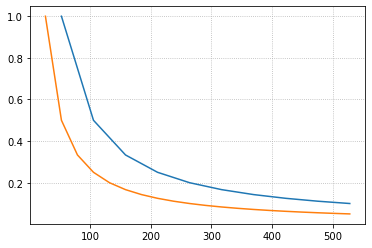

In [274]:
def inv_dist(bins, power):
    if not bins:
        return
    wts = 1 / np.array(bins) ** power
    return wts / np.max(wts)


plt.plot(xbins, inv_dist(xbins, 1))
plt.plot(ybins, inv_dist(ybins, 1))

In [275]:
def update_variogram(values, lag_dict):
    """updated current experimental variogram with `values`
    TODO: account for lags with no pairs
    """
    if not lag_dict:
        return
    nlags = len(lag_dict)
    expvario = np.full(nlags, np.nan)
    for n in range(nlags):
        tail = values[lag_dict[n][:, 0]]
        head = values[lag_dict[n][:, 1]]
        if len(tail) == 0 or len(head) == 0:
            #             print(f"No pairs in lag {n}!")
            continue
        expvario[n] = 1 / (2 * len(tail)) * np.sum((tail - head) ** 2)
    # set missing values to sill
    expvario[np.isnan(expvario)] = np.var(values)
    return expvario


xvario = update_variogram(AL, xlag_dict)
yvario = update_variogram(AL, ylag_dict)

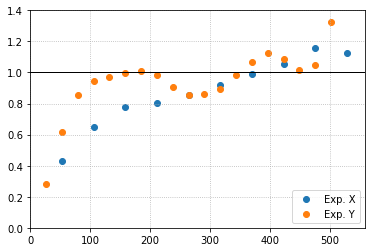

In [276]:
fig, ax = plt.subplots()
ax.scatter(xbins, xvario, label="Exp. X")
ax.scatter(ybins, yvario, label="Exp. Y")
ax.set_ylim(0, 1.4)
ax.set_xlim(0)
ax.axhline(1.0, c="k", lw=1)
ax.legend(loc=4)

In [277]:
def get_vario_model_points(model_pts, lags):
    """get variogram model values at corresponding experimental lag dists"""
    xvals = np.arange(len(model_pts))
    return np.interp(lags, xvals, model_pts)


def expvario_loss(exp_pts, model_pts, lags, lag_wts, sill):
    """squared error between experimental points and variogram model"""
    if not np.array(exp_pts).any():
        return 0.0
    exp_pts /= sill
    model_at_lags = get_vario_model_points(model_pts, lags)
    return np.sum(((exp_pts - model_at_lags) ** 2) * lag_wts)

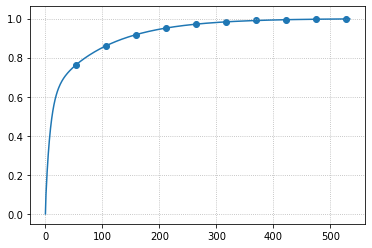

In [278]:
plt.scatter(xbins, get_vario_model_points(target_x, xbins))
plt.plot(target_x)

In [279]:
#
# variograms
#


def objective_vario(AL, targets, lag_dicts, lags, scale):
    """continuous variogram objective function"""
    tx, ty, *tz = targets
    xlag, ylag, *zlag = lag_dicts
    lx, ly, *lz = lags
    xvario = update_variogram(AL, xlag)
    yvario = update_variogram(AL, ylag)
    zvario = update_variogram(AL, zlag)
    xlag_wts = inv_dist(lx, 1.0)
    ylag_wts = inv_dist(ly, 1.0)
    zlag_wts = inv_dist(lz, 1.0)
    sill = np.var(AL)
    objv = 0.0
    objv += expvario_loss(xvario, tx, lx, xlag_wts, sill)
    objv += expvario_loss(yvario, ty, ly, ylag_wts, sill)
    objv += expvario_loss(zvario, tz, lz, zlag_wts, sill)
    return objv * scale


def init_vario(
    Y, targets, lag_dicts, lags, connections, parameters, bounds, afunc, seed,
):
    """initialize continuous variogram objective function"""
    rng = np.random.default_rng(seed)
    x = rng.uniform(bounds[0], bounds[1], size=np.sum(connections))
    parameters = vector_to_matrices(parameters, connections, x)
    AL = nn.linear_forward(Y, parameters, afunc)
    objv = objective_vario(AL, targets, lag_dicts, lags, scale=1.0)
    return objv

In [280]:
objective_vario(
    AL, [target_x, target_y], [xlag_dict, ylag_dict], [xbins, ybins], scale=1.0
)

0.48076471950815675

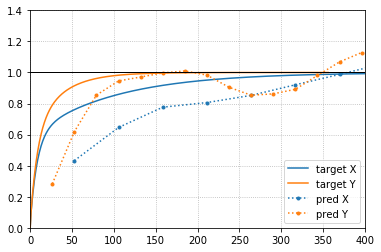

In [281]:
fig, ax = plt.subplots()
gx = update_variogram(AL, xlag_dict)
gy = update_variogram(AL, ylag_dict)
ax.plot(target_x, c="C0", label="target X")
ax.plot(target_y, c="C1", label="target Y")
ax.plot(xbins, gx, c="C0", ls=":", marker=".", label="pred X")
ax.plot(ybins, gy, c="C1", ls=":", marker=".", label="pred Y")
ax.axhline(1.0, c="k", lw=1)
ax.set_ylim(0, 1.4)
ax.set_xlim(0, nx * 0.5)
ax.legend()

In [282]:
#
# indicator variograms
#


def objective_ivario(AL, targets, lag_dicts, lags, thresholds, scale):
    """continuous variogram objective function"""
    xlag, ylag, *zlag = lag_dicts
    lx, ly, *lz = lags
    xlag_wts = inv_dist(lx, 1.0)
    ylag_wts = inv_dist(ly, 1.0)
    zlag_wts = inv_dist(lz, 1.0)
    AL_i, ivars = indicator_transform(AL, thresholds.values())
    nq = len(thresholds)
    objv = 0.0
    for j, q in enumerate(thresholds):
        tx, ty, *tz = targets[q]
        sill = ivars[j]
        xivario = update_variogram(AL_i[:, j], xlag)
        yivario = update_variogram(AL_i[:, j], ylag)
        zivario = update_variogram(AL_i[:, j], zlag)
        objv += expvario_loss(xivario, tx, lx, xlag_wts, sill)
        objv += expvario_loss(yivario, ty, ly, ylag_wts, sill)
        objv += expvario_loss(zivario, tz, lz, zlag_wts, sill)
    return objv * scale


def init_ivario(
    Y, targets, lag_dicts, lags, connections, parameters, bounds, afunc, seed,
):
    """initialize continuous variogram objective function"""
    rng = np.random.default_rng(seed)
    x = rng.uniform(bounds[0], bounds[1], size=np.sum(connections))
    parameters = vector_to_matrices(parameters, connections, x)
    AL = nn.linear_forward(Y, parameters, afunc)
    objv = objective_ivario(AL, targets, lag_dicts, lags, thresholds, scale=1.0)
    return objv

In [283]:
objective_ivario(
    AL, ivarios, [xlag_dict, ylag_dict], [xbins, ybins], thresholds, scale=1.0
)

0.6584650186712262

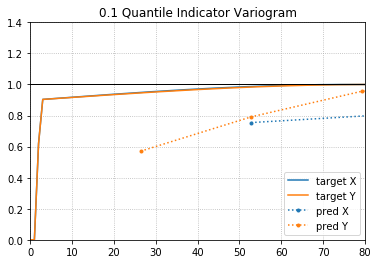

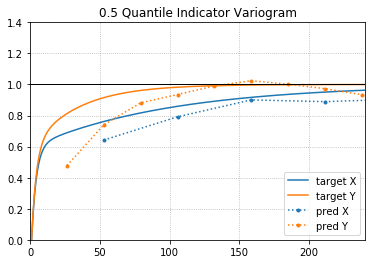

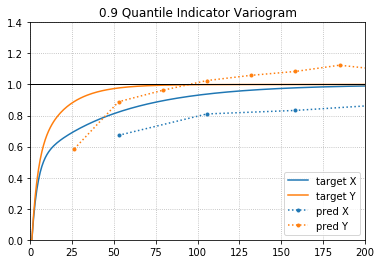

In [284]:
AL_i, ivars = indicator_transform(AL, thresholds.values())
for j, q in enumerate(quantiles):
    fig, ax = plt.subplots()
    igx = update_variogram(AL_i[:, j], xlag_dict) / ivars[j]
    igy = update_variogram(AL_i[:, j], ylag_dict) / ivars[j]
    ax.plot(ivarios[q][0], c="C0", label="target X")
    ax.plot(ivarios[q][1], c="C1", label="target Y")
    ax.plot(xbins, igx, c="C0", ls=":", marker=".", label="pred X")
    ax.plot(ybins, igy, c="C1", ls=":", marker=".", label="pred Y")
    ax.set_title(f"{q} Quantile Indicator Variogram")
    ax.axhline(1.0, c="k", lw=1)
    ax.set_ylim(0, 1.4)
    ax.set_xlim(0, nx * xscale[j])
    ax.legend()

## Runs

In [285]:
def objective_histogram(hist, target, scale):
    """relative mse between histogram bins"""
    #     objv = np.sum(((hist - target) / target) ** 2) / len(hist)
    objv = np.sum(((hist - target)) ** 2) / len(hist)
    return objv * scale


def objective_runs(
    AL, target, thresholds, runs_above, maxrun, ncomps, ndh, scale
):
    """cumulative run frequency objective fucntion"""
    AL_i, ivars = indicator_transform(AL, thresholds.values())
    nq = len(thresholds)
    objv = 0.0
    for j, q in enumerate(thresholds):
        X = AL_i[:, j].reshape(ncomps, ndh, order="F")
        temp_runs = np.zeros(maxrun)
        for n in range(ndh):
            run_freqs = binary_runs(X[:, n], runs_above)["cum_runs_freqs"][
                :maxrun
            ]
            temp_runs += np.pad(run_freqs, (0, maxrun - len(run_freqs)))
        objv += objective_histogram(temp_runs, target[q], scale) * (1 / nq)
    return objv


def init_runs(
    Y,
    target,
    maxrun,
    ncomps,
    ndh,
    thresholds,
    runs_above,
    connections,
    parameters,
    bounds,
    afunc,
    seed,
):
    """initialize runs objective"""
    rng = np.random.default_rng(seed)
    x = rng.uniform(bounds[0], bounds[1], size=np.sum(connections))
    parameters = vector_to_matrices(parameters, connections, x)
    AL = nn.linear_forward(Y, parameters, afunc)
    objv = objective_runs(
        AL, target, thresholds, runs_above, maxrun, ncomps, ndh, scale=1.0
    )
    return objv

In [286]:
objective_runs(
    AL, global_runs, thresholds, runs_above, maxrun, ncomps, ndh, scale=1.0
)

71177.65333333332

## n-point connectivity

In [287]:
#
# n-point connectivity
#


# def objective_npoint(AL, target, thresholds, nstep, ncomps, ndh, scale):
#     """n-point connectivity objective fucntion"""
#     AL_i, ivars = indicator_transform(AL, thresholds.values())
#     objv = 0.0
#     for j, q in enumerate(thresholds):
#         npoint = n_pt_conn(AL_i[:, j].reshape(ncomps, ndh, order="F"), nstep)
#         objv += np.sum((npoint - target[q]) ** 2) / len(npoint)
#     return objv * scale


# def init_npoint(
#     Y, target, thresholds, nstep, connections, parameters, bounds, afunc, seed
# ):
#     """initialize n-point connectivity objective"""
#     rng = np.random.default_rng(seed)
#     x = rng.uniform(bounds[0], bounds[1], size=np.sum(connections))
#     parameters = vector_to_matrices(parameters, connections, x)
#     AL = nn.linear_forward(Y, parameters, afunc)
#     objv = objective_npoint(
#         AL, target, thresholds, nstep, ncomps, ndh, scale=1.0
#     )
#     return objv


def objective_npoint(AL, target, thresholds, nstep, ncomps, ndh, scale):
    """n-point connectivity objective fucntion"""
    AL_i, ivars = indicator_transform(AL, thresholds.values())
    objv = 0.0
    for j, q in enumerate(thresholds):
        npoint = n_pt_conn(AL_i[:, j].reshape(ncomps, ndh, order="F"), nstep)
        objv += objective_histogram(npoint, target[q], scale)
    return objv


def init_npoint(
    Y, target, thresholds, nstep, connections, parameters, bounds, afunc, seed
):
    """initialize n-point connectivity objective"""
    rng = np.random.default_rng(seed)
    x = rng.uniform(bounds[0], bounds[1], size=np.sum(connections))
    parameters = vector_to_matrices(parameters, connections, x)
    AL = nn.linear_forward(Y, parameters, afunc)
    objv = objective_npoint(
        AL, target, thresholds, nstep, ncomps, ndh, scale=1.0
    )
    return objv

In [288]:
objective_npoint(AL, target_npoint, thresholds, nstep, ncomps, ndh, scale=1.0)

0.023437460151975294

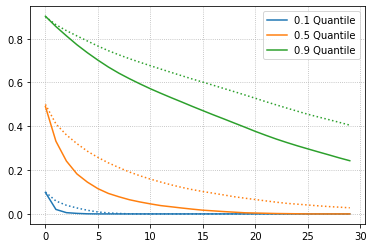

In [289]:
for j, q in enumerate(thresholds):
    npoint = n_pt_conn(AL_i[:, j].reshape(ncomps, ndh, order="F"), nstep=nstep)
    plt.plot(target_npoint[q], c=f"C{j}", label=f"{q} Quantile")
    plt.plot(npoint, c=f"C{j}", ls=":")
    plt.legend()

# Objective Scaling

In [290]:
def objective_scaling(
    Y,
    connections,
    parameters,
    bounds,
    lag_dicts,
    lags,
    thresholds,
    runs_above,
    maxrun,
    nstep,
    ncomps,
    ndh,
    afunc,
    maxpert,
    seed,
    vario=True,
    vario_target=None,
    ivario=True,
    ivario_target=None,
    runs=True,
    runs_target=None,
    npoint=True,
    npoint_target=None,
):
    rng = np.random.default_rng(seed)

    objinit = np.zeros(4)
    objscale = np.ones(4)
    objdelta = np.zeros(4)

    # initalize objective values
    if vario:
        objinit[0] = init_vario(
            Y,
            vario_target,
            lag_dicts,
            lags,
            connections,
            parameters,
            bounds,
            afunc,
            seed,
        )
    if ivario:
        objinit[1] = init_ivario(
            Y,
            ivario_target,
            lag_dicts,
            lags,
            connections,
            parameters,
            bounds,
            afunc,
            seed,
        )
    if runs:
        objinit[2] = init_runs(
            Y,
            runs_target,
            maxrun,
            ncomps,
            ndh,
            thresholds,
            runs_above,
            connections,
            parameters,
            bounds,
            afunc,
            seed,
        )
    if npoint:
        objinit[3] = init_npoint(
            Y,
            npoint_target,
            thresholds,
            nstep,
            connections,
            parameters,
            bounds,
            afunc,
            seed,
        )

    for m in range(maxpert):

        # draw random parameter vector
        x = rng.uniform(bounds[0], bounds[1], size=np.sum(connections))

        # reshape x into matrices
        parameters = vector_to_matrices(parameters, connections, x)

        # caluclate the forward pass
        AL = nn.linear_forward(Y, parameters, afunc)

        # approximate objective contributions
        if vario:
            temp_obj_vario = objective_vario(
                AL, vario_target, lag_dicts, lags, scale=objscale[0]
            )
            if temp_obj_vario < 0.0:
                temp_obj_vario = objinit[0]
            objdelta[0] += np.abs(objinit[0] - temp_obj_vario)

        if ivario:
            temp_obj_ivario = objective_ivario(
                AL,
                ivario_target,
                lag_dicts,
                lags,
                thresholds,
                scale=objscale[1],
            )
            if temp_obj_ivario < 0.0:
                temp_obj_ivario = objinit[1]
            objdelta[1] += np.abs(objinit[1] - temp_obj_ivario)

        if runs:
            temp_obj_runs = objective_runs(
                AL,
                runs_target,
                thresholds,
                runs_above,
                maxrun,
                ncomps,
                ndh,
                scale=objscale[2],
            )
            if temp_obj_runs < 0.0:
                temp_obj_runs = objinit[2]
            objdelta[2] += np.abs(objinit[2] - temp_obj_runs)

        if npoint:
            temp_obj_npt = objective_npoint(
                AL,
                npoint_target,
                thresholds,
                nstep,
                ncomps,
                ndh,
                scale=objscale[3],
            )
            if temp_obj_npt < 0.0:
                temp_obj_npt = objinit[3]
            objdelta[3] += np.abs(objinit[3] - temp_obj_npt)

    # scale objective components
    if vario:
        objscale[0] = maxpert / objdelta[0]
    if ivario:
        objscale[1] = maxpert / objdelta[1]
    if runs:
        objscale[2] = maxpert / objdelta[2]
    if npoint:
        objscale[3] = maxpert / objdelta[3]

    # rescale factor
    rescale = 0.0
    for objv, scl in zip(objinit, objscale):
        rescale += scl * objv
    rescale = 1 / max(rescale, 1e-10)
    objscale *= rescale

    return objscale

In [298]:
from objective_cls import Objective

fobj = Objective(Ysimd)
bounds = fobj.generate_bounds(parameters, connections) + [(0, 1)] * tbias
afunc = nn.sigmoid
maxpert = 1000
seed = 1044

objscale = objective_scaling(
    Ysimd,
    connections,
    parameters,
    bounds,
    [xlag_dict, ylag_dict],
    [xbins, ybins],
    thresholds,
    runs_above,
    maxrun,
    nstep,
    ncomps,
    ndh,
    afunc,
    maxpert,
    seed,
    vario=True,
    vario_target=[target_x, target_y],
    ivario=True,
    ivario_target=ivarios,
    runs=True,
    runs_target=global_runs,
    npoint=True,
    npoint_target=target_npoint,
)

targets = [
    "Continous Variogram",
    "Indicator Variograms",
    "Cumulative Runs",
    "n-Point Connectivity",
]
for name, oscl in zip(targets, objscale):
    print(f"{name} scale factor: {oscl}\n")

ValueError: shape mismatch: objects cannot be broadcast to a single shape

In [292]:
# utils.to_pickle("objscale.pkl", objscale)

# Objective Function

In [293]:
def network_lmr_objective(x, *args):
    """objective function for network lmr"""

    # caluclate the forward pass
    params = vector_to_matrices(parameters, connections, x)
    AL = nn.linear_forward(Y, params, afunc)

    # initialize objective value
    objv = 0.0

    # continuous variogram
    if vario:
        objv += objective_vario(AL, target_vario, lag_dicts, lags, objscale[0])

    # indicator variogram
    if ivario:
        objv += objective_ivario(
            AL, target_ivario, lag_dicts, lags, thresholds, objscale[1]
        )

    # cumulative runs
    if runs:
        #         objv += objective_runs(
        #             AL, target_runs, thresholds, runs_above, wts, nhist, objscale[2]
        #         )
        objv += objective_runs(
            AL,
            target_runs,
            thresholds,
            runs_above,
            maxrun,
            ncomps,
            ndh,
            objscale[2],
        )

    # npoint connectivity runs
    if npoint:
        objv += objective_npoint(
            AL, target_npoint, thresholds, nstep, ncomps, ndh, objscale[3]
        )

    return objv

In [294]:
# lag_dicts = [xlag_dict, ylag_dict]
# lags = [xbins, ybins]
# target_vario = [target_x, target_y]
# target_ivario = ivarios
# target_runs = global_runs
# Y = Ysimd.copy()

# vario = True
# ivario = True
# runs = True
# npoint = True

# args = (
#     parameters,
#     connections,
#     Y,
#     target_vario,
#     target_ivario,
#     target_runs,
#     target_npoint,
#     #     wts,
#     #     nhist,
#     maxrun,
#     nstep,
#     ncomps,
#     ndh,
#     runs_above,
#     thresholds,
#     afunc,
#     objscale,
#     vario,
#     ivario,
#     runs,
#     npoint,
# )
# results = list(
#     opt.de(
#         network_lmr_objective,
#         args,
#         bounds=[bounds] * tconn,
#         popsize=15,
#         mut=(0.5, 1),
#         crossp=0.9,
#         its=1500,
#         seed=21,
#         K=25,
#         g=1e-5,
#     )
# )

In [295]:
# objective = []
# for result in results:
#     objective.append(result[-1])
# plt.plot(objective)

In [296]:
lag_dicts = [xlag_dict, ylag_dict, {}]
lags = [xbins, ybins, []]
target_vario = [target_x, target_y, []]
target_ivario = ivarios
target_runs = global_runs

vario = True
ivario = True
runs = True
npoint = True

# args = (
#     parameters,
#     connections,
#     target_vario,
#     target_ivario,
#     target_runs,
#     target_npoint,
#     lag_dicts,
#     lags,
#     maxrun,
#     nstep,
#     ncomps,
#     ndh,
#     runs_above,
#     thresholds,
#     afunc,
#     objscale,
#     vario,
#     ivario,
#     runs,
#     npoint,
# )

args = (
    parameters,
    connections,
    biases,
    target_vario,
    target_ivario,
    target_runs,
    target_npoint,
    lag_dicts,
    lags,
    maxrun,
    nstep,
    dhids,
    dh_lens,
    runs_above,
    thresholds,
    afunc,
    objscale,
    vario,
    ivario,
    runs,
    npoint,
)

from pde import pde

results = pde(
    fobj, args, bounds=bounds, popsize=15, its=500, seed=21,
)
plt.plot(results[-1])

ValueError: cannot reshape array of size 2 into shape (3,10)

In [297]:
bounds

(0.0, 1.0)

In [76]:
# from scipy.optimize import differential_evolution

# from objective_cls import Objective

# args_test = (
#     parameters,
#     connections,
#     target_vario,
#     target_ivario,
#     target_runs,
#     target_npoint,
#     lag_dicts,
#     lags,
#     wts,
#     nhist,
#     nstep,
#     ncomps,
#     ndh,
#     runs_above,
#     thresholds,
#     afunc,
#     objscale,
#     vario,
#     ivario,
#     runs,
#     npoint,
# )

# # objective = Objective(Ysimd)
# # xtest = np.random.uniform(size=tconn)
# # objective(xtest, args_test)

# result = differential_evolution(
#     Objective(Ysimd),
#     bounds=[bounds] * tconn,
#     args=args_test,
#     maxiter=10,
#     updating="deferred",
#     disp=True,
#     seed=49,
#     workers=-1,
# )
# result.x, result.fun

In [77]:
# from yabox.algorithms import DE, PDE

# from fobj import create_loss

# args_test = (
#     parameters,
#     connections,
#     target_vario,
#     target_ivario,
#     target_runs,
#     target_npoint,
#     lag_dicts,
#     lags,
#     wts,
#     nhist,
#     nstep,
#     ncomps,
#     ndh,
#     runs_above,
#     thresholds,
#     afunc,
#     objscale,
#     vario,
#     ivario,
#     runs,
#     npoint,
# )

# f = create_loss(Ysimd, args_test)
# f(np.random.uniform(size=tconn))

# xo, yo = PDE(f, [bounds] * tconn, maxiters=10).solve(show_progress=True)
# xo, yo

In [78]:
# de_params = parameters.copy()
# de_weights = []
# num_wts = np.cumsum([0] + connections)
# for ell in range(1, len(parameters) // 2 + 1):
#     shape = de_params["W" + str(ell)].shape
#     de_params["W" + str(ell)] = results[-1][0][
#         num_wts[ell - 1] : num_wts[ell]
#     ].reshape(shape)
#     de_weights.append(de_params["W" + str(ell)])

de_params = parameters.copy()
de_weights = []
num_wts = np.cumsum([0] + connections)
for ell in range(1, len(parameters) // 2 + 1):
    shape = de_params["W" + str(ell)].shape
    de_params["W" + str(ell)] = results[0][
        num_wts[ell - 1] : num_wts[ell]
    ].reshape(shape)
    de_weights.append(de_params["W" + str(ell)])

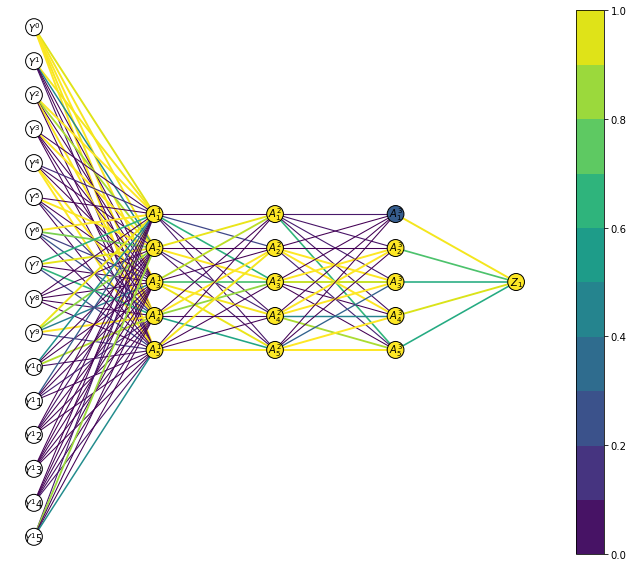

In [79]:
fig, ax = plt.subplots(figsize=(12, 10))
ax.axis("off")
cmap = "viridis"  # "Spectral_r"
draw_weighted_neural_net(
    ax,
    0.05,
    0.95,
    0.0,
    1.0,
    layer_dims,
    "Y",
    "A",
    "Z",
    10,
    node_wts=None,
    edge_wts=de_weights,
    cmap=cmap,
)
sm, _ = get_rgb(0, cmap, 0, 1)
plt.colorbar(sm, boundaries=np.arange(0, 1.1, 0.1))

In [99]:
out_var = nn.node_variance(Ysimd, de_params, afunc)
out_var

{'W1': array([0.62938076, 0.59763843, 0.40741572, 0.59365846, 0.53490743]),
 'W2': array([0.5044164 , 0.60358511, 0.66263052, 0.36268801, 0.63632506]),
 'W3': array([0.04306464, 0.64388105, 0.76970467, 0.75379093, 0.71879057]),
 'W4': array([6.32410285])}

In [101]:
de_weights

[array([[0.9055688 , 0.93300253, 0.95      , 0.07122147, 0.15954221,
         0.05      , 0.95      , 0.62389201, 0.05093712, 0.92026274,
         0.49590716, 0.31867505, 0.05      , 0.05      , 0.05      ,
         0.11317663],
        [0.93881788, 0.47058032, 0.83491565, 0.95      , 0.06748231,
         0.94574657, 0.76750283, 0.91477905, 0.06928674, 0.79417311,
         0.05      , 0.05325165, 0.09407678, 0.05      , 0.05      ,
         0.81587429],
        [0.95      , 0.05019482, 0.05      , 0.05      , 0.05      ,
         0.05      , 0.22151312, 0.05      , 0.05      , 0.42648653,
         0.05      , 0.05400499, 0.05      , 0.05      , 0.05      ,
         0.0515574 ],
        [0.93943893, 0.05      , 0.94532868, 0.05      , 0.95      ,
         0.1904515 , 0.29185488, 0.63563505, 0.05370793, 0.94991376,
         0.84467105, 0.13132154, 0.05      , 0.05992768, 0.07635106,
         0.05      ],
        [0.95      , 0.09973241, 0.05      , 0.05      , 0.9472909 ,
         0.05  

# Summarize Results

In [81]:
de_AL = nn.linear_forward(Ysimd, de_params, afunc)
de_AL_i, ivars = indicator_transform(de_AL, thresholds.values())

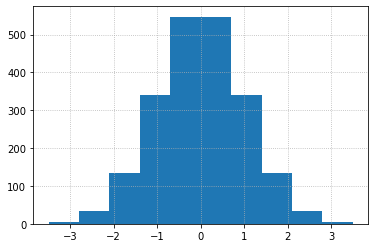

In [82]:
_ = plt.hist(de_AL)

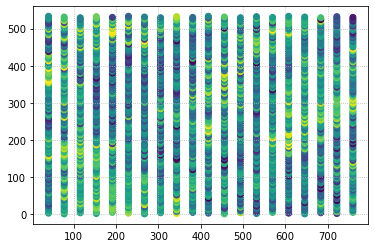

In [83]:
plt.scatter(coords[:, 0], coords[:, 1], c=de_AL, vmin=-2.5, vmax=2.5)

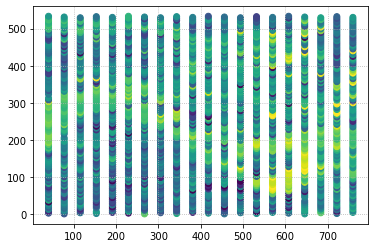

In [84]:
plt.scatter(comps["X"], comps["Y"], c=comps[var], vmin=-2.5, vmax=2.5)

## Variograms

In [85]:
xvario = update_variogram(de_AL, xlag_dict)
yvario = update_variogram(de_AL, ylag_dict)

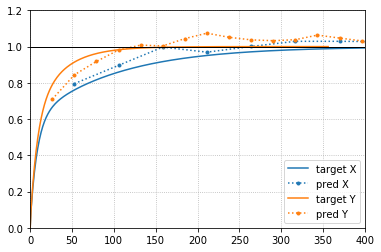

In [86]:
fig, ax = plt.subplots()
ax.plot(target_x, c="C0", label="target X")
ax.plot(xbins, xvario, c="C0", ls=":", marker=".", label="pred X")
ax.plot(target_y, c="C1", label="target Y")
ax.plot(ybins, yvario, c="C1", ls=":", marker=".", label="pred Y")
ax.axhline(1.0, c="k", lw=1)
ax.set_ylim(0, 1.2)
ax.set_xlim(0, nx * 0.5)
ax.legend()

In [87]:
igx = update_variogram(de_AL_i[:, 2], xlag_dict)  # / ivars[0]
igx

array([0.07877489, 0.08231917, 0.08482895, 0.08180973, 0.08391372,
       0.08613775, 0.08758808, 0.08947098, 0.09209121, 0.09750275])

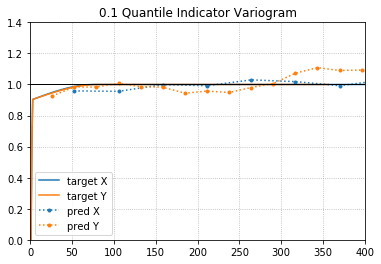

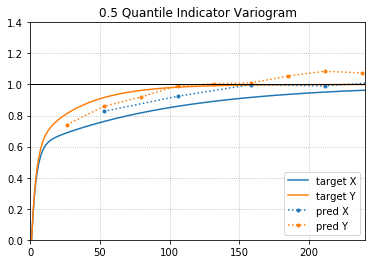

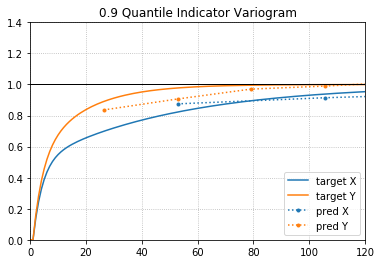

In [88]:
xscale = [0.5, 0.3, 0.15]
for j, q in enumerate(quantiles):
    fig, ax = plt.subplots()
    igx = update_variogram(de_AL_i[:, j], xlag_dict) / ivars[j]
    igy = update_variogram(de_AL_i[:, j], ylag_dict) / ivars[j]
    ax.plot(ivarios[q][0], c="C0", label="target X")
    ax.plot(ivarios[q][1], c="C1", label="target Y")
    ax.plot(xbins, igx, c="C0", ls=":", marker=".", label="pred X")
    ax.plot(ybins, igy, c="C1", ls=":", marker=".", label="pred Y")
    ax.set_title(f"{q} Quantile Indicator Variogram")
    ax.axhline(1.0, c="k", lw=1)
    ax.set_ylim(0, 1.4)
    ax.set_xlim(0, nx * xscale[j])
    ax.legend()

 ## Runs

In [89]:
# for j, q in enumerate(thresholds):
#     fig, ax = plt.subplots()
#     target_cruns = np.sort(target_runs[q])
#     cruns = binary_runs(de_AL_i[:, j], runs_above=True)["cum_runs"]
#     cruns, _ = init_ecdf(cruns, wts=None, nhist=nhist)
#     pvals = [i / (nhist + 1) for i in range(1, nhist + 1)]
#     ax.plot(target_cruns, pvals, label="target CDF")
#     ax.plot(cruns, pvals, ls=":", c="C0", label="pred CDF")
#     ax.set_title(f"{q} Quantile")
#     ax.legend(loc=4)

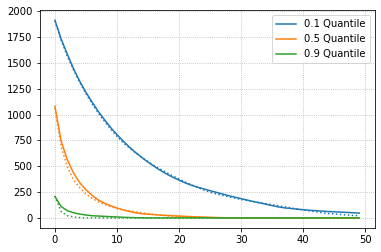

In [90]:
fig, ax = plt.subplots()
for j, q in enumerate(thresholds):
    X = de_AL_i[:, j].reshape(ncomps, ndh, order="F")
    temp_runs = np.zeros(maxrun)
    for n in range(ndh):
        run_freqs = binary_runs(X[:, n], runs_above)["cum_runs_freqs"][:maxrun]
        temp_runs += np.pad(run_freqs, (0, maxrun - len(run_freqs)))
    ax.plot(global_runs[q], c=f"C{j}", label=f"{q} Quantile")
    ax.plot(temp_runs, c=f"C{j}", ls=":")
ax.legend()

## n-Point Connectivity

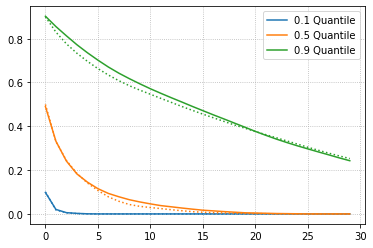

In [91]:
for j, q in enumerate(thresholds):
    npoint = n_pt_conn(
        de_AL_i[:, j].reshape(ncomps, ndh, order="F"), nstep=nstep
    )
    plt.plot(target_npoint[q], c=f"C{j}", label=f"{q} Quantile")
    plt.plot(npoint, c=f"C{j}", ls=":")
    plt.legend()

# Mix Gridded Factors

In [95]:
# AL_grid = nn.linear_forward(Ysim, de_params, afunc)

In [93]:
# fig, axes = plt.subplots(1, 2, figsize=(10, 4))
# origin = "lower"
# vmin = -2.5
# vmax = 2.5
# im0 = axes[0].imshow(reference, origin=origin, vmin=vmin, vmax=vmax)
# axes[0].set_title("Reference")
# im1 = axes[1].imshow(
#     AL_grid.reshape(ny, nx), origin=origin, vmin=vmin, vmax=vmax
# )
# axes[1].set_title("Network Mixture")

# plt.colorbar(im0, ax=axes[0])
# plt.colorbar(im1, ax=axes[1])